In [10]:
import os

os.environ["EQX_ON_ERROR"] = "nan"
import sys

import healpy as hp
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax_healpy import get_clusters , get_cutout_from_mask , combine_masks , from_cutout_to_fullmap
from matplotlib.patches import Patch

sys.path.append("../data")
from generate_maps import get_mask

<Figure size 1000x500 with 0 Axes>

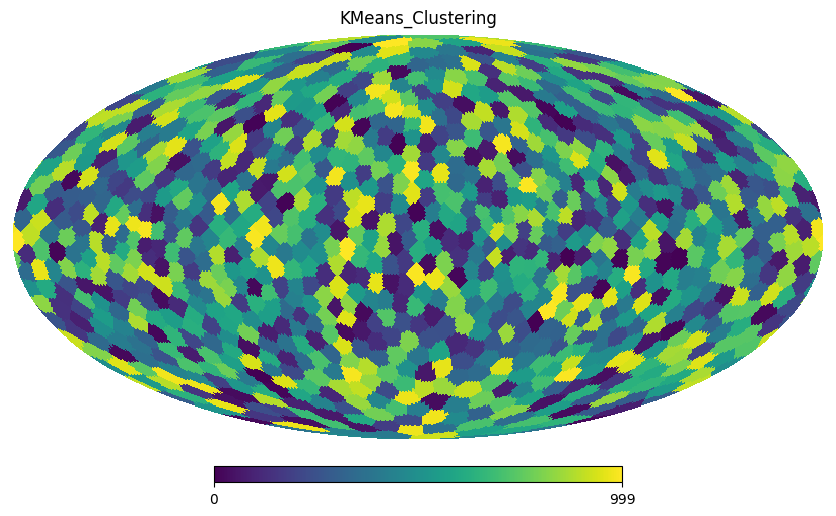

In [2]:
nside = 64
npixels = hp.nside2npix(nside)

mask = jnp.ones(npixels)
(indices,) = jnp.where(mask == 1)

full_map = get_clusters(mask, indices, 1000, jax.random.PRNGKey(0), max_centroids=1000)

# Set up subplots
fig = plt.figure(figsize=(10, 5))
# Plot each map
hp.mollview(full_map, title="KMeans_Clustering", bgcolor=(0.0,) * 4)
# Display the plot
plt.savefig("kmeans_clustering.pdf", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()

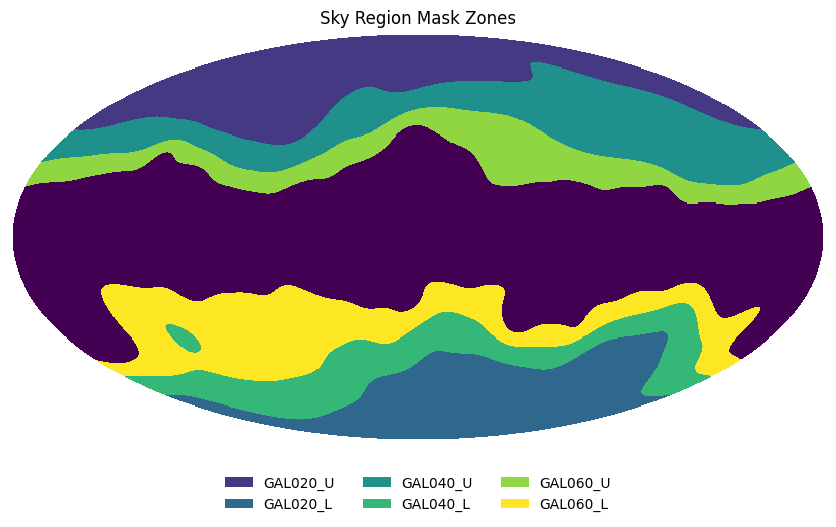

In [3]:
# Load binary masks
gal020_u = get_mask("GAL020_U", nside=2048)
gal020_l = get_mask("GAL020_L", nside=2048)
gal040_u = get_mask("GAL040_U", nside=2048)
gal040_l = get_mask("GAL040_L", nside=2048)
gal060_u = get_mask("GAL060_U", nside=2048)
gal060_l = get_mask("GAL060_L", nside=2048)

# Combine into a single labeled mask
full_mask = gal020_u * 1 + gal020_l * 2 + gal040_u * 3 + gal040_l * 4 + gal060_u * 5 + gal060_l * 6

# Labels and matching values
labels = [
    "GAL020_U",
    "GAL020_L",
    "GAL040_U",
    "GAL040_L",
    "GAL060_U",
    "GAL060_L",
]
values = [1, 2, 3, 4, 5, 6]

# Plot using default mollview settings (uses viridis automatically)
hp.mollview(full_mask, title="Sky Region Mask Zones", min=0, max=6, cbar=False, bgcolor=(0.0,) * 4)

# Get the default colormap and compute colors for the integer zones
cmap = plt.cm.viridis
normed_vals = np.array(values) / 6  # Normalize to [0, 1]
colors = [cmap(val) for val in normed_vals]

# Create custom legend
legend_elements = [Patch(facecolor=color, label=label) for label, color in zip(labels, colors)]

# Add the legend under the map
plt.legend(
    handles=legend_elements, loc="lower center", bbox_to_anchor=(0.5, -0.2), ncol=3, frameon=False
)

plt.savefig("sky_region_mask_zones.pdf", dpi=1200, bbox_inches="tight", transparent=True)
plt.show()

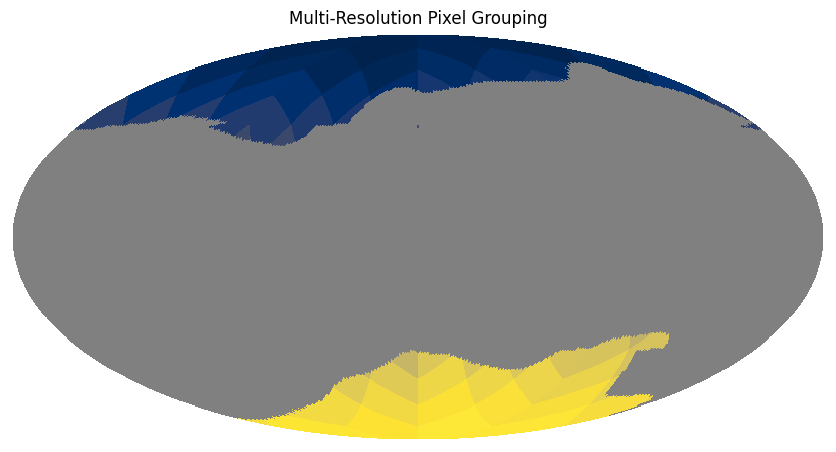

In [4]:
# Load binary masks

gal020 = np.array(get_mask("GAL020", nside=64))
nside = 64
npix = nside**2 * 12
ipix = np.arange(npix)


def ud_grade(ipix, nside_in, nside_out):
    if nside_out == 0:
        return np.zeros_like(ipix)
    else:
        lowered = hp.ud_grade(ipix, nside_out=nside_out)
        return hp.ud_grade(lowered, nside_out=nside_in)


ud_beta_d_map = ud_grade(ipix, nside, 4).astype(np.float64)

(indices,) = np.where(gal020 == 0)


def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices.astype(np.float64)


ud_beta_d_map = normalize_array(ud_beta_d_map)
ud_beta_d_map[indices] = hp.UNSEEN


hp.mollview(
    ud_beta_d_map,
    title="Multi-Resolution Pixel Grouping",
    cmap="cividis",  # or "cubehelix", "YlGnBu", "Greys", etc.
    cbar=False,
)
plt.savefig("multi_resolution_pixel_grouping.pdf", dpi=1200, bbox_inches="tight", transparent=True)

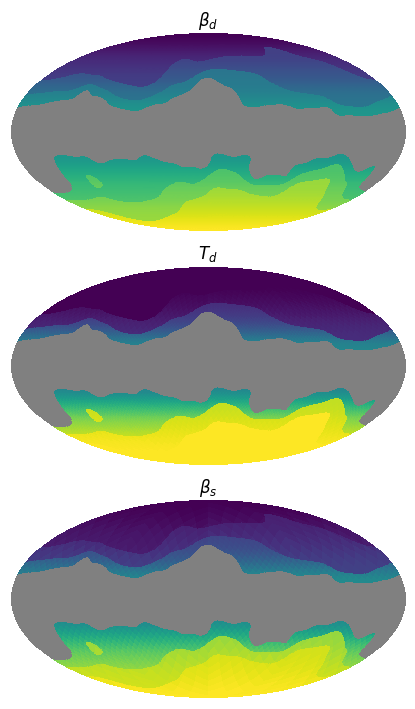

In [48]:
indices_list = []
maps_list = []
masks = []

nside = 256
npix = nside**2 * 12
ipix = np.arange(npix)

ud_grades = [(64, 0, 2), (64, 4, 2), (64, 8, 4),(64, 8, 4), (64, 4, 2), (64, 0, 2)]

ud_grades = jax.tree.map(lambda x : int(x * nside / 64) , ud_grades)
previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}
for udgrade, mask_name in zip(ud_grades,  ["GAL020_U", "GAL040_U",  "GAL060_U", "GAL060_L", "GAL040_L" , "GAL020_L"]):
    mask = get_mask(mask_name , nside=nside)
    (indices,) = jnp.where(mask == 1)

    def ud_grade(ipix, nside_in, nside_out):
        if nside_out == 0:
            return np.zeros_like(ipix)
        else:
            lowered = hp.ud_grade(ipix, nside_out=nside_out)
            return hp.ud_grade(lowered, nside_out=nside_in)

    ud_beta_d_map = ud_grade(ipix, nside, udgrade[0])
    ud_temp_d_map = ud_grade(ipix, nside, udgrade[1])
    ud_beta_pl_map = ud_grade(ipix, nside, udgrade[2])

    # These downgraded maps serve as our patch indices.
    patch_indices = {
        "beta_dust_patches": ud_beta_d_map,
        "temp_dust_patches": ud_temp_d_map,
        "beta_pl_patches": ud_beta_pl_map,
    }
    patch_indices = get_cutout_from_mask(patch_indices, indices)

    def normalize_array(arr):
        unique_vals, indices = np.unique(arr, return_inverse=True)
        return indices

    patch_indices = jax.tree.map(normalize_array, patch_indices)
    patch_indices = jax.tree.map(lambda x, p: x + p, patch_indices, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, patch_indices, previous_mask_size
    )

    indices_list.append(indices)
    maps_list.append(patch_indices)
    masks.append(mask)

def normalize_array(arr):
    unique_vals, indices = np.unique(arr, return_inverse=True)
    return indices

full_mask = np.logical_or.reduce(masks, axis=0)
full_indices, = jnp.where(full_mask == 1)

full_map = combine_masks(maps_list, indices_list, nside)
full_map = get_cutout_from_mask(full_map , full_indices)
full_map = jax.tree.map(normalize_array, full_map)
full_map = from_cutout_to_fullmap(full_map, full_indices, nside)

min_val = 0


figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_map["beta_dust_patches"],
    title=rf"$\beta_d$",
    min=min_val,
    max=np.max(full_map["beta_dust_patches"]),
    cbar=False,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_map["temp_dust_patches"],
    title=rf"$T_d$",
    min=min_val,
    max=np.max(full_map["temp_dust_patches"]),
    cbar=False,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_map["beta_pl_patches"],
    title=rf"$\beta_s$",
    min=min_val,
    max=np.max(full_map["beta_pl_patches"]),
    cbar=False,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)

plt.savefig("multires_patch_layout.pdf", dpi=1200, bbox_inches="tight", transparent=True)


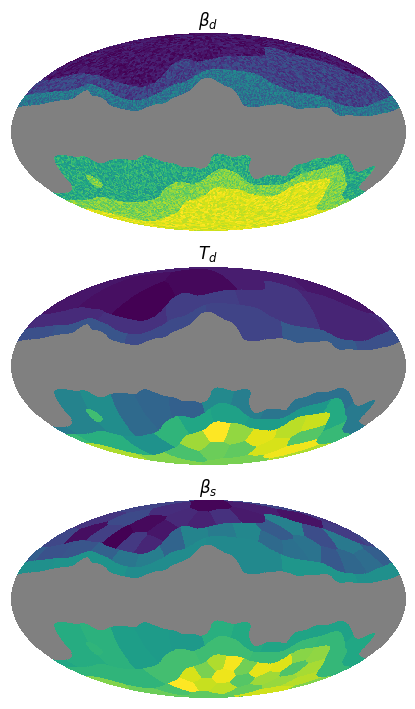

In [47]:
nside = 256
npixels = hp.nside2npix(nside)

GAL020_U = get_mask("GAL020_U")
(indices,) = jnp.where(GAL020_U == 1)

GAL020_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 20,
}
GAL020_L_patch_count = {
    "temp_dust_patches": 15,
    "beta_dust_patches": 2000,
    "beta_pl_patches": 25,
}
GAL040_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 20,
}
GAL040_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 3000,
    "beta_pl_patches": 5,
}
GAL060_U_patch_count = {
    "temp_dust_patches": 5,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 5,
}
GAL060_L_patch_count = {
    "temp_dust_patches": 10,
    "beta_dust_patches": 4000,
    "beta_pl_patches": 10,
}

patch_count_list = [
    GAL020_U_patch_count,
    GAL040_U_patch_count,
    GAL060_U_patch_count,
    GAL060_L_patch_count,
    GAL040_L_patch_count,
    GAL020_L_patch_count,
]

indices_list = []
maps_list = []
masks = []

previous_mask_size = {
    "beta_dust_patches": 0,
    "temp_dust_patches": 0,
    "beta_pl_patches": 0,
}

for patch_count, mask_name in zip(
    patch_count_list, ["GAL020_U", "GAL040_U",  "GAL060_U", "GAL060_L", "GAL040_L" , "GAL020_L"]
):
    mask = get_mask(mask_name, nside)
    (indices,) = jnp.where(mask == 1)

    full_map = jax.tree.map(
        lambda x: get_clusters(
            mask, indices, x, jax.random.key(0), max_centroids=4000, initial_sample_size=1
        ),
        patch_count,
    )
    full_map = get_cutout_from_mask(full_map, indices)

    full_map = jax.tree.map(lambda x, p: x + p, full_map, previous_mask_size)
    previous_mask_size = jax.tree.map(
        lambda x, p: p + np.unique(x).size, full_map, previous_mask_size
    )

    maps_list.append(full_map)
    indices_list.append(indices)
    masks.append(mask)

full_full_map = combine_masks(maps_list, indices_list, nside)

min_val = 0

figure = plt.figure(figsize=(4, 7))

hp.mollview(
    full_full_map["beta_dust_patches"],
    title=rf"$\beta_d$",
    min=min_val,
    max=np.max(full_full_map["beta_dust_patches"]),
    cbar=False,
    sub=(3, 1, 1),
    bgcolor=(0, 0, 0, 0),  # Transparent background
)
hp.mollview(
    full_full_map["temp_dust_patches"],
    title=rf"$T_d$",
    min=min_val,
    max=np.max(full_full_map["temp_dust_patches"]),
    cbar=False,
    sub=(3, 1, 2),
    bgcolor=(0, 0, 0, 0),
)
hp.mollview(
    full_full_map["beta_pl_patches"],
    title=rf"$\beta_s$",
    min=min_val,
    max=np.max(full_full_map["beta_pl_patches"]),
    cbar=False,
    sub=(3, 1, 3),
    bgcolor=(0, 0, 0, 0),
)

plt.savefig("kmeans_patch_layout.pdf", dpi=1200, bbox_inches="tight", transparent=True)

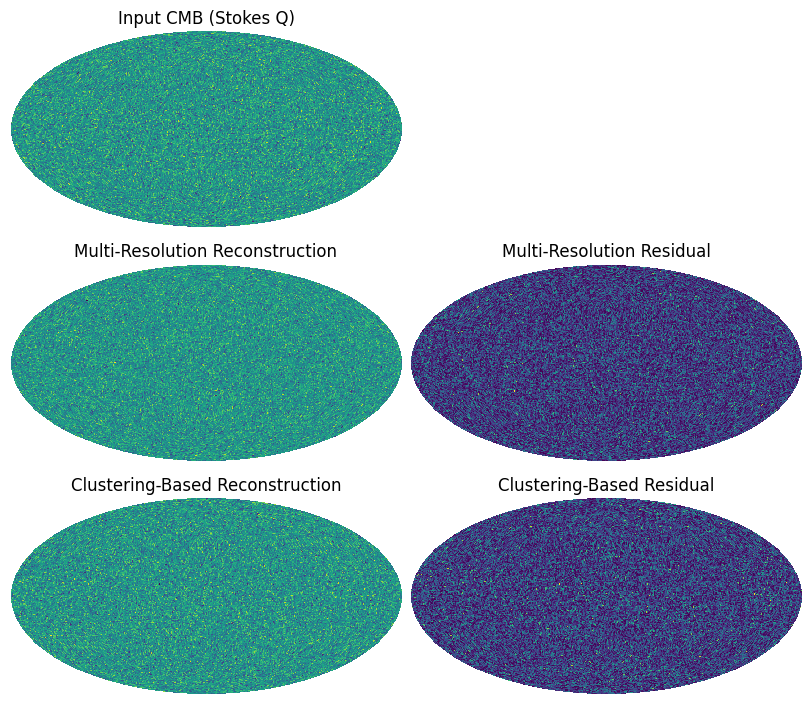

In [49]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

nside = 64
npix = 12 * nside**2

random_map = np.random.normal(size=(npix,))
random_other = np.random.normal(size=(npix,))
random_last = np.random.normal(size=(npix,))

figure = plt.figure(figsize=(8, 7))

# Row 1
hp.mollview(random_map, title="Input CMB (Stokes Q)", fig=fig, sub=(3, 2, 1), cbar=False, bgcolor=(0.0,) * 4)

# Row 2
hp.mollview(random_other, title="Multi-Resolution Reconstruction", fig=fig, sub=(3, 2, 3), cbar=False, bgcolor=(0.0,) * 4)
hp.mollview(np.abs(random_map - random_other), title="Multi-Resolution Residual", fig=fig, sub=(3, 2, 4), cbar=False, bgcolor=(0.0,) * 4)

# Row 3
hp.mollview(random_last, title="Clustering-Based Reconstruction", fig=fig, sub=(3, 2, 5), cbar=False, bgcolor=(0.0,) * 4)
hp.mollview(np.abs(random_map - random_last), title="Clustering-Based Residual", fig=fig, sub=(3, 2, 6), cbar=False, bgcolor=(0.0,) * 4)

fig.savefig("cmb_reconstruction_comparison_Q.pdf", bbox_inches="tight" , dpi=1200, transparent=True)


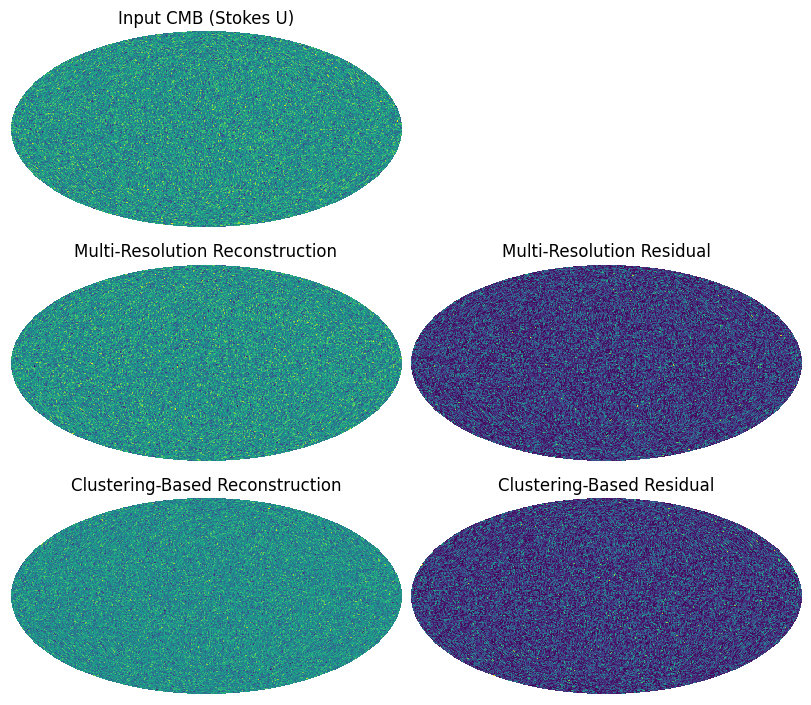

In [50]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

nside = 64
npix = 12 * nside**2

random_map = np.random.normal(size=(npix,))
random_other = np.random.normal(size=(npix,))
random_last = np.random.normal(size=(npix,))

figure = plt.figure(figsize=(8, 7))

# Row 1
hp.mollview(random_map, title="Input CMB (Stokes U)", fig=fig, sub=(3, 2, 1), cbar=False, bgcolor=(0.0,) * 4)

# Row 2
hp.mollview(random_other, title="Multi-Resolution Reconstruction", fig=fig, sub=(3, 2, 3), cbar=False, bgcolor=(0.0,) * 4)
hp.mollview(np.abs(random_map - random_other), title="Multi-Resolution Residual", fig=fig, sub=(3, 2, 4), cbar=False, bgcolor=(0.0,) * 4)

# Row 3
hp.mollview(random_last, title="Clustering-Based Reconstruction", fig=fig, sub=(3, 2, 5), cbar=False, bgcolor=(0.0,) * 4)
hp.mollview(np.abs(random_map - random_last), title="Clustering-Based Residual", fig=fig, sub=(3, 2, 6), cbar=False, bgcolor=(0.0,) * 4)

fig.savefig("cmb_reconstruction_comparison_U.pdf", bbox_inches="tight" , dpi=1200, transparent=True)
